In [8]:
import numpy as np
import os
import json
import collections as col
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
TRAINING_PATH = '/home/jack/Downloads/snli_1.0/snli_1.0_train.jsonl'
DEV_PATH = '/home/jack/Downloads/snli_1.0/snli_1.0_dev.jsonl'
TEST_PATH = '/home/jack/Downloads/removable/USB_DISK/snli_1.0/snli_1.0_test.jsonl'

TRAINING_VECTORS_PATH = '/home/jack/NLP/csr.npz'
DEV_VECTORS_PATH = '/home/jack/NLP/dev_csr.npz'
TEST_VECTORS_PATH = ''

SAVE_TO_FILE = False
LOAD_FROM_FILE = False

STOP = stopwords.words('english')

In [10]:
def save_sparse_vectors(file_name, array, labels):
    np.savez(file_name, data = array.data, indices = array.indices, indptr = array.indptr, shape = array.shape, label_data = labels)

def load_sparse_vectors(file_name):
    loader = np.load(file_name)
    return (csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape = loader['shape']), loader['label_data'])

In [11]:
def pos_stoplist(pos):
    return pos == 'NN' or pos == 'JJ' or 'VB' in pos

def pos_strip(sentence_parse, stoplist_function):
    m = re.finditer('\((\w+) (\w+)\)', sentence_parse)
    tags = [(match.group(2), match.group(1)) for match in m if stoplist_function(match.group(1))]
    return tags

def extract_pair(line):
    json_pair = json.loads(line)
    pair = {'sentence1': json_pair['sentence1'],
            'sentence1_pos': pos_strip(json_pair['sentence1_parse'], pos_stoplist),
            'sentence2': json_pair['sentence2'],
            'sentence2_pos': pos_strip(json_pair['sentence2_parse'], pos_stoplist),
            'label': json_pair['gold_label']}
    return pair

In [12]:
def cross_unigram_counter(pair):
    cross_unigrams = []
    for word1 in pair['sentence1']:
        for word2 in pair['sentence2']:
            cross_unigrams.append((word1, word2))

    return col.Counter(cross_unigrams)

def cross_unigram_stoplist_counter(pair):
    sentence1 = (word for word in pair['sentence1'] if word not in STOP)
    sentence2 = (word for word in pair['sentence2'] if word not in STOP)
    
    cross_unigrams = []
    for word1 in sentence1:
        for word2 in sentence2:
            cross_unigrams.append(hash((word1, word2)))

    return col.Counter(cross_unigrams)

def cross_unigram_pos_counter(pair):
    cross_unigrams = []
    for word1 in pair['sentence1_pos']:
        for word2 in pair['sentence2_pos']:
            cross_unigrams.append((word1, word2))

    return col.Counter(cross_unigrams)

def cross_unigram_pos_justwords_counter(pair):
    cross_unigrams = []
    for word1 in pair['sentence1_pos']:
        for word2 in pair['sentence2_pos']:
            cross_unigrams.append((word1[0], word2[0]))

    return col.Counter(cross_unigrams)

def extract_pairs(file_path):
    with open(file_path, 'rb') as f:
        for line in f:
            yield extract_pair(line)

def extract_counters(pairs, feature_extractor):
    for pair in pairs:
        yield feature_extractor(pair)

def calculate_vectors(training_path, testing_path, feature_extractor):
#     print 'Calculating Training Vectors'
#     pairs = []
#     with open(training_path, 'rb') as f:
#         count = samples
#         for line in f:
#             pairs.append(extract_pair(line))
#             if count == 0:
#                 break
#             else:
#                 count -= 1

#     print 'Calculating Testing Vectors'
#     dev_pairs = []
#     with open(testing_path, 'rb') as f:
#         count = samples
#         for line in f:
#             dev_pairs.append(extract_pair(line))
#             if count == 0:
#                 break
#             else:
#                 count -= 1


    print 'Calculating Cross Unigrams'
#     labels = [pair['label'] for pair in pairs]
#     dev_labels = [pair['label'] for pair in dev_pairs]
    labels = [pair['label'] for pair in extract_pairs(training_path)]
    dev_labels = [pair['label'] for pair in extract_pairs(testing_path)]
    
#     counters = [feature_extractor(pair) for pair in pairs]
#     dev_counters = [feature_extractor(pair) for pair in dev_pairs]
 
    print 'Training Vectorizer'
    vectorizer = DictVectorizer()
    vectorizer.fit(extract_counters(extract_pairs(training_path), feature_extractor))

    print 'Vectorizing unigrams'
    vectors = vectorizer.transform(extract_counters(extract_pairs(training_path), feature_extractor))
    dev_vectors = vectorizer.transform(extract_counters(extract_pairs(testing_path), feature_extractor))

    if SAVE_TO_FILE:
        print 'Saving to File'
        save_sparse_vectors(TRAINING_PATH, vectors, labels)
        save_sparse_vectors(DEV_PATH, dev_vectors, dev_labels)

    return (vectors, labels, dev_vectors, dev_labels)

In [98]:
if LOAD_FROM_FILE:
    try:
        vectors, labels = load_sparse_vectors(TRAINING_VECTORS_PATH)
        dev_vectors, dev_labels = load_sparse_vectors(DEV_VECTORS_PATH)
        print 'Loaded Vectors from File'
    except Exception as e:
        print 'Failed to load from File calculating feature vectors'
        vectors, labels, dev_vectors, dev_labels = calculate_vectors(TRAINING_PATH, DEV_PATH)
else:
    print 'Computing feature vectors'
    vectors, labels, dev_vectors, dev_labels = calculate_vectors(TRAINING_PATH, DEV_PATH)

Computing feature vectors
Calculating Training Vectors
Calculating Testing Vectors
Calculating Cross Unigrams
Training Vectorizer
Vectorizing unigrams


In [16]:
%time vectors, labels, dev_vectors, dev_labels = calculate_vectors(TRAINING_PATH, DEV_PATH, cross_unigram_counter)
print vectors.shape

Calculating Cross Unigrams


KeyboardInterrupt: 

In [15]:
%time vectors, labels, dev_vectors, dev_labels = calculate_vectors(TRAINING_PATH, DEV_PATH, cross_unigram_stoplist_counter)
print vectors.shape

Calculating Cross Unigrams
Training Vectorizer
Vectorizing unigrams
CPU times: user 22min 3s, sys: 7.94 s, total: 22min 11s
Wall time: 22min 14s
(550152, 2534)


In [17]:
%time vectors, labels, dev_vectors, dev_labels = calculate_vectors(TRAINING_PATH, DEV_PATH, cross_unigram_pos_counter)
print vectors.shape

Calculating Labels
Training Vectorizer
Vectorizing unigrams
CPU times: user 10min 33s, sys: 3.65 s, total: 10min 37s
Wall time: 10min 40s
(550152, 2377572)


In [18]:
%time vectors, labels, dev_vectors, dev_labels = calculate_vectors(TRAINING_PATH, DEV_PATH, cross_unigram_pos_justwords_counter)
print vectors.shape

Calculating Cross Unigrams
Training Vectorizer
Vectorizing unigrams
CPU times: user 9min 39s, sys: 9.62 s, total: 9min 49s
Wall time: 9min 57s
(550152, 2120044)


In [20]:
save_sparse_vectors(TRAINING_VECTORS_PATH, vectors, labels)
save_sparse_vectors(DEV_VECTORS_PATH, dev_vectors, dev_labels)

In [7]:
vectors, labels = load_sparse_vectors(TRAINING_VECTORS_PATH)
dev_vectors, dev_labels = load_sparse_vectors(DEV_VECTORS_PATH)

In [21]:
#random_state gives the seeed, none seams to always give the same result
perceptron = Perceptron(shuffle=True, n_iter=5, random_state=1000)
print 'Training Perceptron'
perceptron = perceptron.fit(vectors, labels)
print 'Testing perceptron'
predictions = perceptron.predict(dev_vectors)
score = perceptron.score(dev_vectors, dev_labels)
print score

Training Perceptron
Testing perceptron
0.6118


In [17]:
print vectors[0:10000,:].shape

(10000, 2377572)


In [8]:
print 'POS Cross Unigrams'
step = 10000
scores = []
for i in range(1, 55):
    samples = i * step
    #print '-' * 5 + str(samples) + '-' * 5 
    perceptron = Perceptron(shuffle=True, n_iter=5, random_state=1000)
    perceptron = perceptron.fit(vectors[0:samples,:], labels[0:samples])
    score = perceptron.score(dev_vectors, dev_labels)
    #print 'Score: ', score
    scores.append(score)

POS Cross Unigrams


In [11]:
print confusion_matrix(dev_labels, predictions, labels=['entailment', 'contradiction', 'neutral'])
print classification_report(dev_labels, predictions,labels=['entailment', 'contradiction', 'neutral'])

[[2176  496  643]
 [ 568 2191  515]
 [ 879  623 1721]]
             precision    recall  f1-score   support

 entailment       0.59      0.65      0.62      3329
contradiction       0.65      0.67      0.66      3278
    neutral       0.59      0.53      0.56      3235

avg / total       0.61      0.62      0.61      9842



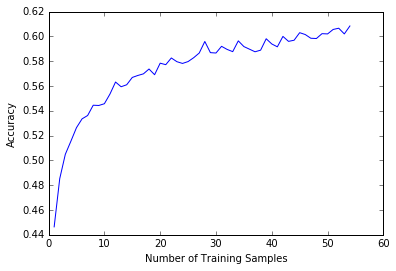

In [10]:
plt.figure()
plt.plot(range(1,55), scores)
#plt.axis([1, 550, 0.4, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Number of Training Samples')
plt.show()